**Project Note – Shehryar (ID: P2952028)**
Hi! My Name is **Shehryar Shehryar** and my **Student ID is P2952028**. In this project, I applied ANN, CNN, U-Net, and Vision Transformer on the Fashion-MNIST dataset. U-Net was implemented with downsampling, bottleneck, and upsampling stages, and all models were visualized with their output predictions. Accuracy and loss graphs, along with confusion matrices, were generated for performance evaluation. Finally, a detailed comparison highlighted strengths and weaknesses of each model, emphasizing deep learning effectiveness on image classification tasks.

In [2]:
#Step 0
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch version: 2.8.0+cu126
CUDA available: True
Using device: cuda


In [3]:
#Step 1
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import random, time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
#Step 2
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set   = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_size = 50000
val_size   = len(full_train) - train_size
train_set, val_set = random_split(full_train, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

print("Train size:", len(train_set))
print("Val size:", len(val_set))
print("Test size:", len(test_set))

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.7MB/s]

Train size: 50000
Val size: 10000
Test size: 10000


In [5]:
#Step 3
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [6]:
#Step 4
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return running_loss/total, correct/total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            running_loss += loss.item() * X.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())
    all_preds, all_labels = np.concatenate(all_preds), np.concatenate(all_labels)
    return running_loss/total, correct/total, all_preds, all_labels

def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, model_name="model"):
    hist = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    best_acc, best_state = 0.0, None
    start = time.time()
    for epoch in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(val_loss); hist["val_acc"].append(val_acc)
        print(f"{model_name} Epoch {epoch}/{epochs} | train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f}")
        if val_acc > best_acc:
            best_acc, best_state = val_acc, model.state_dict()
    print(f"Training finished in {(time.time()-start)/60:.2f} min | Best val acc={best_acc:.4f}")
    if best_state: model.load_state_dict(best_state)
    return model, hist


In [7]:
#Step 5
class ANN(nn.Module):
    def __init__(self, hidden1=256, hidden2=128, dropout=0.3):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 10)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x)); x = self.drop(x)
        x = F.relu(self.fc2(x)); x = self.drop(x)
        return self.fc3(x)

ann = ANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ann = optim.Adam(ann.parameters(), lr=1e-3, weight_decay=1e-5)
ann, hist_ann = fit(ann, train_loader, val_loader, criterion, optimizer_ann, device, epochs=12, model_name="ANN")

ANN Epoch 1/12 | train_loss=0.6201 acc=0.7772 | val_loss=0.4480 acc=0.8375
ANN Epoch 2/12 | train_loss=0.4417 acc=0.8398 | val_loss=0.3947 acc=0.8535
ANN Epoch 3/12 | train_loss=0.4105 acc=0.8523 | val_loss=0.3661 acc=0.8642
ANN Epoch 4/12 | train_loss=0.3794 acc=0.8621 | val_loss=0.3519 acc=0.8731
ANN Epoch 5/12 | train_loss=0.3620 acc=0.8690 | val_loss=0.3585 acc=0.8735
ANN Epoch 6/12 | train_loss=0.3497 acc=0.8717 | val_loss=0.3424 acc=0.8725
ANN Epoch 7/12 | train_loss=0.3380 acc=0.8764 | val_loss=0.3353 acc=0.8777
ANN Epoch 8/12 | train_loss=0.3296 acc=0.8803 | val_loss=0.3340 acc=0.8792
ANN Epoch 9/12 | train_loss=0.3244 acc=0.8807 | val_loss=0.3228 acc=0.8836
ANN Epoch 10/12 | train_loss=0.3118 acc=0.8836 | val_loss=0.3113 acc=0.8881
ANN Epoch 11/12 | train_loss=0.3054 acc=0.8880 | val_loss=0.3178 acc=0.8841
ANN Epoch 12/12 | train_loss=0.2999 acc=0.8887 | val_loss=0.3261 acc=0.8843
Training finished in 2.26 min | Best val acc=0.8881


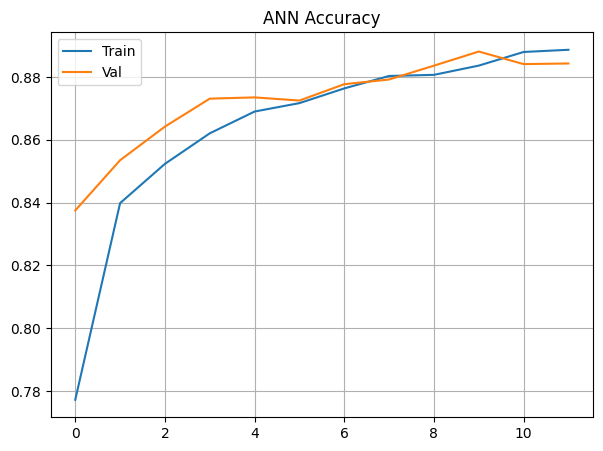

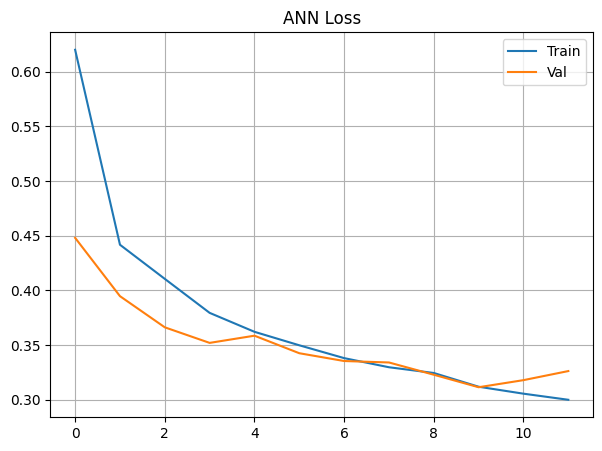

In [8]:
#Step 6
plt.figure(figsize=(7,5))
plt.plot(hist_ann['train_acc'], label='Train'); plt.plot(hist_ann['val_acc'], label='Val')
plt.title('ANN Accuracy'); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,5))
plt.plot(hist_ann['train_loss'], label='Train'); plt.plot(hist_ann['val_loss'], label='Val')
plt.title('ANN Loss'); plt.legend(); plt.grid(True); plt.show()


In [9]:
#Step 7
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*5*5,256)
        self.fc2 = nn.Linear(256,10)
        self.drop = nn.Dropout(0.4)
    def forward(self,x):
        x = F.relu(self.conv1(x)); x = self.pool(x)
        x = F.relu(self.conv2(x)); x = self.pool(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x)); x = self.drop(x)
        return self.fc2(x)

cnn = CNN().to(device)
optimizer_cnn = optim.Adam(cnn.parameters(), lr=1e-3, weight_decay=1e-5)
cnn, hist_cnn = fit(cnn, train_loader, val_loader, criterion, optimizer_cnn, device, epochs=12, model_name="CNN")


CNN Epoch 1/12 | train_loss=0.5795 acc=0.7861 | val_loss=0.4038 acc=0.8539
CNN Epoch 2/12 | train_loss=0.3781 acc=0.8623 | val_loss=0.3327 acc=0.8801
CNN Epoch 3/12 | train_loss=0.3243 acc=0.8804 | val_loss=0.3000 acc=0.8877
CNN Epoch 4/12 | train_loss=0.2949 acc=0.8907 | val_loss=0.2900 acc=0.8937
CNN Epoch 5/12 | train_loss=0.2685 acc=0.9011 | val_loss=0.2735 acc=0.8976
CNN Epoch 6/12 | train_loss=0.2491 acc=0.9081 | val_loss=0.2593 acc=0.9073
CNN Epoch 7/12 | train_loss=0.2327 acc=0.9155 | val_loss=0.2490 acc=0.9087
CNN Epoch 8/12 | train_loss=0.2182 acc=0.9203 | val_loss=0.2549 acc=0.9074
CNN Epoch 9/12 | train_loss=0.2018 acc=0.9250 | val_loss=0.2353 acc=0.9152
CNN Epoch 10/12 | train_loss=0.1861 acc=0.9311 | val_loss=0.2428 acc=0.9152
CNN Epoch 11/12 | train_loss=0.1786 acc=0.9331 | val_loss=0.2347 acc=0.9167
CNN Epoch 12/12 | train_loss=0.1647 acc=0.9390 | val_loss=0.2412 acc=0.9180
Training finished in 2.44 min | Best val acc=0.9180


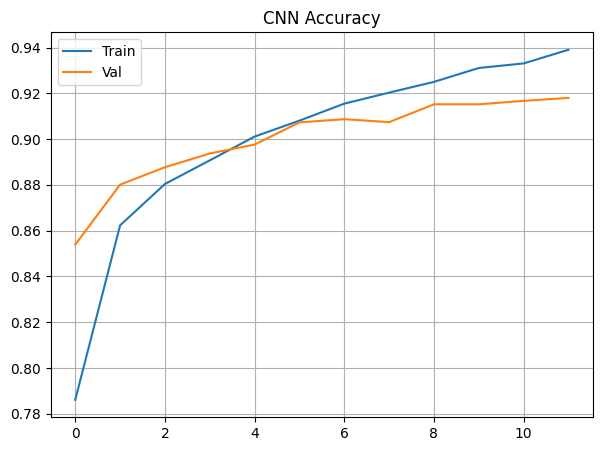

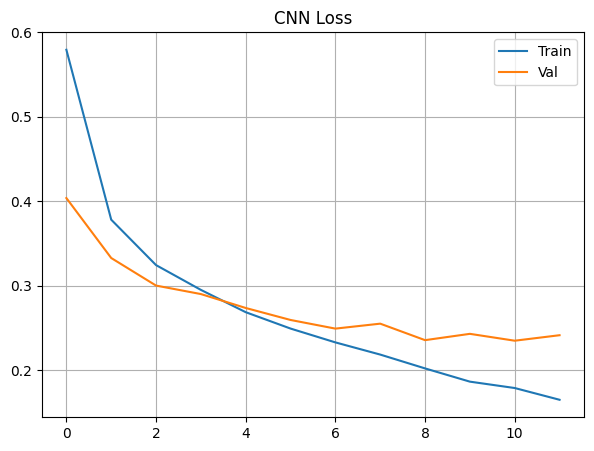

In [10]:
#Step 8
plt.figure(figsize=(7,5))
plt.plot(hist_cnn['train_acc'], label='Train'); plt.plot(hist_cnn['val_acc'], label='Val')
plt.title('CNN Accuracy'); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,5))
plt.plot(hist_cnn['train_loss'], label='Train'); plt.plot(hist_cnn['val_loss'], label='Val')
plt.title('CNN Loss'); plt.legend(); plt.grid(True); plt.show()


In [11]:
#Step 9
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64,128,256,512]):
        super().__init__()
        self.downs, self.ups = nn.ModuleList(), nn.ModuleList()
        self.pool = nn.MaxPool2d(2,2)
        for f in features:
            self.downs.append(self.double_conv(in_channels,f)); in_channels=f
        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(f*2,f,2,2))
            self.ups.append(self.double_conv(f*2,f))
        self.bottleneck = self.double_conv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)

    def double_conv(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c,out_c,3,1,1), nn.ReLU(True),
            nn.Conv2d(out_c,out_c,3,1,1), nn.ReLU(True)
        )

    def forward(self,x):
        skips=[]
        for d in self.downs:
            x=d(x); skips.append(x); x=self.pool(x)
        x=self.bottleneck(x); skips=skips[::-1]
        for idx in range(0,len(self.ups),2):
            x=self.ups[idx](x)
            skip=skips[idx//2]
            if x.shape!=skip.shape: x=F.interpolate(x,size=skip.shape[2:])
            x=torch.cat((skip,x),dim=1)
            x=self.ups[idx+1](x)
        return self.final_conv(x)

unet = UNet().to(device)
print(unet)


UNet(
  (downs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
   

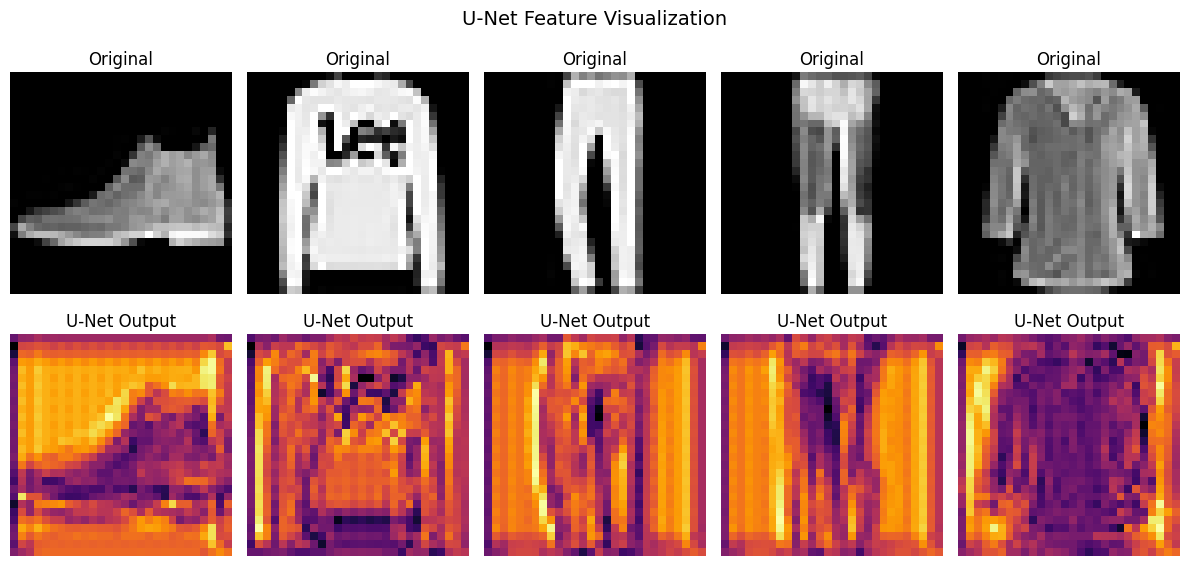

In [12]:
#Step 10
unet.eval()
images, _ = next(iter(test_loader))
images = images.to(device)
with torch.no_grad():
    outputs = torch.sigmoid(unet(images)).cpu().numpy()
images = images.cpu().numpy()

n = 5
plt.figure(figsize=(12,6))
for i in range(n):
    plt.subplot(2,n,i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title("Original"); plt.axis('off')
    plt.subplot(2,n,i+n+1)
    plt.imshow(outputs[i][0], cmap='inferno')
    plt.title("U-Net Output"); plt.axis('off')
plt.suptitle("U-Net Feature Visualization", fontsize=14)
plt.tight_layout(); plt.show()


In [13]:
#Step 11
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=7, emb_size=64, img_size=28):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
        self.pos_embed = nn.Parameter(torch.randn((img_size//patch_size)**2 + 1, emb_size))
    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x).flatten(2).transpose(1,2)   # (B, N, E)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos_embed
        return x

class ViT(nn.Module):
    def __init__(self, img_size=28, patch_size=7, emb_size=64, num_heads=4, num_layers=4, num_classes=10):
        super().__init__()
        self.patch_embed = PatchEmbedding(1, patch_size, emb_size, img_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes)
        )
    def forward(self, x):
        x = self.patch_embed(x)
        x = self.transformer(x)
        cls_token = x[:,0]
        return self.mlp_head(cls_token)

vit = ViT().to(device)
optimizer_vit = optim.Adam(vit.parameters(), lr=1e-3, weight_decay=1e-5)
vit, hist_vit = fit(vit, train_loader, val_loader, criterion, optimizer_vit, device, epochs=12, model_name="VisionTransformer")


VisionTransformer Epoch 1/12 | train_loss=1.1072 acc=0.5770 | val_loss=0.6455 acc=0.7701
VisionTransformer Epoch 2/12 | train_loss=0.5549 acc=0.8021 | val_loss=0.4760 acc=0.8291
VisionTransformer Epoch 3/12 | train_loss=0.4834 acc=0.8273 | val_loss=0.4428 acc=0.8343
VisionTransformer Epoch 4/12 | train_loss=0.4501 acc=0.8380 | val_loss=0.4075 acc=0.8587
VisionTransformer Epoch 5/12 | train_loss=0.4243 acc=0.8498 | val_loss=0.4055 acc=0.8548
VisionTransformer Epoch 6/12 | train_loss=0.4041 acc=0.8558 | val_loss=0.3858 acc=0.8633
VisionTransformer Epoch 7/12 | train_loss=0.3881 acc=0.8616 | val_loss=0.3960 acc=0.8567
VisionTransformer Epoch 8/12 | train_loss=0.3733 acc=0.8671 | val_loss=0.3568 acc=0.8691
VisionTransformer Epoch 9/12 | train_loss=0.3617 acc=0.8681 | val_loss=0.3983 acc=0.8595
VisionTransformer Epoch 10/12 | train_loss=0.3586 acc=0.8693 | val_loss=0.3542 acc=0.8737
VisionTransformer Epoch 11/12 | train_loss=0.3439 acc=0.8760 | val_loss=0.3833 acc=0.8654
VisionTransformer E

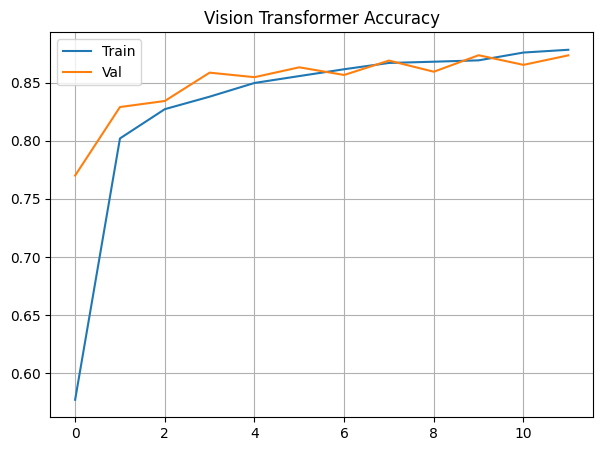

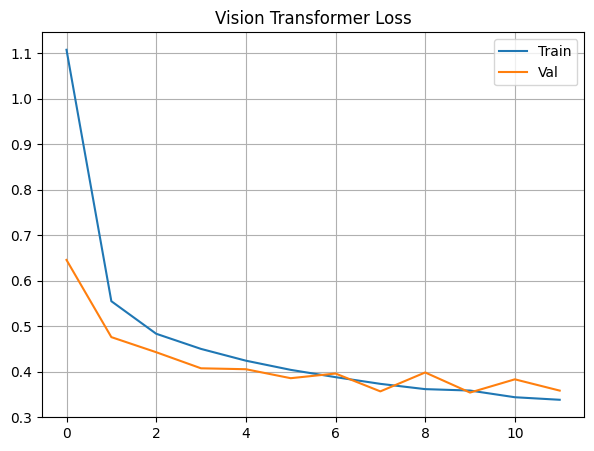

In [14]:
#Step 12
plt.figure(figsize=(7,5))
plt.plot(hist_vit['train_acc'], label='Train'); plt.plot(hist_vit['val_acc'], label='Val')
plt.title('Vision Transformer Accuracy'); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,5))
plt.plot(hist_vit['train_loss'], label='Train'); plt.plot(hist_vit['val_loss'], label='Val')
plt.title('Vision Transformer Loss'); plt.legend(); plt.grid(True); plt.show()


In [15]:
#Step 13
test_loss_ann, test_acc_ann, preds_ann, labels_ann = evaluate(ann, test_loader, criterion, device)
test_loss_cnn, test_acc_cnn, preds_cnn, labels_cnn = evaluate(cnn, test_loader, criterion, device)
test_loss_vit, test_acc_vit, preds_vit, labels_vit = evaluate(vit, test_loader, criterion, device)

print(f"ANN Test Acc: {test_acc_ann:.4f}")
print(f"CNN Test Acc: {test_acc_cnn:.4f}")
print(f"ViT Test Acc: {test_acc_vit:.4f}")


ANN Test Acc: 0.8713
CNN Test Acc: 0.9072
ViT Test Acc: 0.8686


<Figure size 800x600 with 0 Axes>

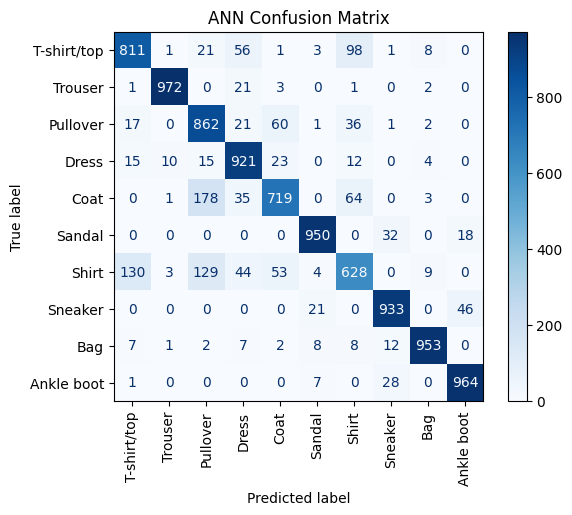

<Figure size 800x600 with 0 Axes>

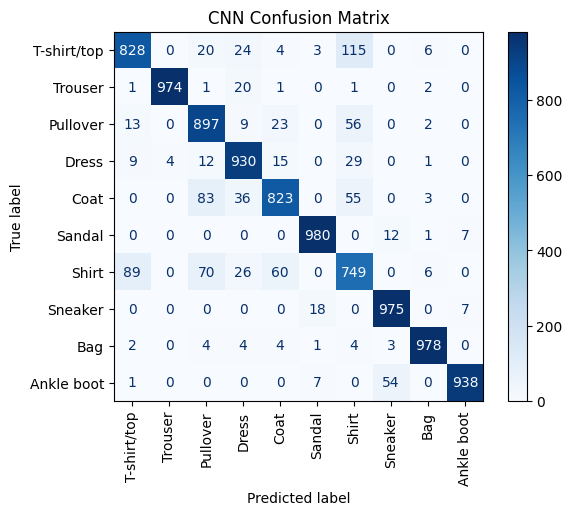

<Figure size 800x600 with 0 Axes>

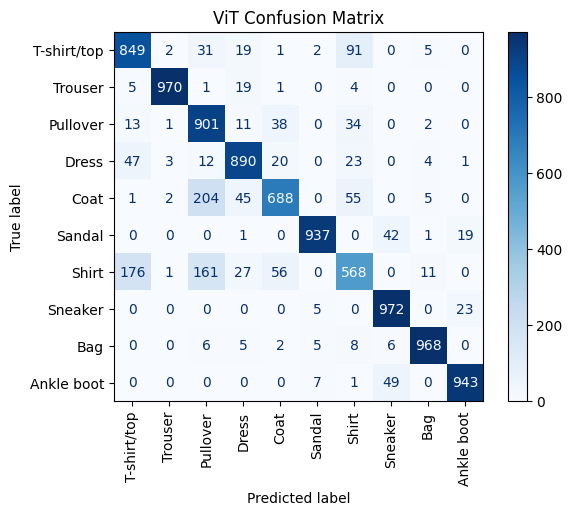

In [16]:
#Step 14
labels_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

for name, lbls, preds in zip(
    ["ANN","CNN","ViT"],
    [labels_ann, labels_cnn, labels_vit],
    [preds_ann, preds_cnn, preds_vit]
):
    cm = confusion_matrix(lbls, preds)
    plt.figure(figsize=(8,6))
    ConfusionMatrixDisplay(cm, display_labels=labels_names).plot(values_format='d', cmap='Blues', xticks_rotation='vertical')
    plt.title(f"{name} Confusion Matrix")
    plt.show()


In [17]:
#Step 15
print("ANN Report:\n", classification_report(labels_ann, preds_ann, target_names=labels_names, digits=4))
print("CNN Report:\n", classification_report(labels_cnn, preds_cnn, target_names=labels_names, digits=4))
print("ViT Report:\n", classification_report(labels_vit, preds_vit, target_names=labels_names, digits=4))


ANN Report:
               precision    recall  f1-score   support

 T-shirt/top     0.8259    0.8110    0.8184      1000
     Trouser     0.9838    0.9720    0.9779      1000
    Pullover     0.7142    0.8620    0.7812      1000
       Dress     0.8335    0.9210    0.8751      1000
        Coat     0.8351    0.7190    0.7727      1000
      Sandal     0.9557    0.9500    0.9529      1000
       Shirt     0.7414    0.6280    0.6800      1000
     Sneaker     0.9265    0.9330    0.9297      1000
         Bag     0.9715    0.9530    0.9621      1000
  Ankle boot     0.9377    0.9640    0.9507      1000

    accuracy                         0.8713     10000
   macro avg     0.8725    0.8713    0.8701     10000
weighted avg     0.8725    0.8713    0.8701     10000

CNN Report:
               precision    recall  f1-score   support

 T-shirt/top     0.8780    0.8280    0.8523      1000
     Trouser     0.9959    0.9740    0.9848      1000
    Pullover     0.8252    0.8970    0.8596      100

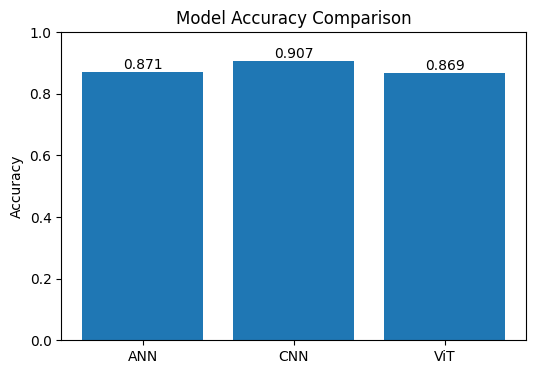

In [18]:
#Step 16
models = ['ANN','CNN','ViT']
accs = [test_acc_ann, test_acc_cnn, test_acc_vit]

plt.figure(figsize=(6,4))
plt.bar(models, accs)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
for i, acc in enumerate(accs):
    plt.text(i, acc+0.01, f"{acc:.3f}", ha='center')
plt.show()
